In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# 현재 모델의 한계점

모델이 분류한 킬 시점의 프레임에서 문제가 발생하였습니다.

1. 현재의 모델은 게임 내의 모든 킬 시점을 파악한다. 즉, 재현율은 1이다. (실제 참인 것을 참으로 판별하는 비율)
2. 반면에 킬인 시점이 아님에도 킬이라고 분류한 프레임이 약 60%를 차지한다. 즉, 정밀도는 0.6이다. (참으로 판별한 프레임 중에 실제 참인 비율은 0.6)
3. 위의 두 지표를 확인하여 볼 때, 현재 모델은 사용할 수 있는 수준이 아니다.

### 해결방안

킬인 시점이 아님에도 킬이라고 분류한 프레임들에서 공통점을 확인하였다. 
- 킬인 시점이 아님에도 킬이라고 분류한 대부분의 프레임은 킬로그와 다른 창들이 함께 뜨는 경우였다.

이러한 공통점을 고려하여 다른 창이 존재하는 프레임 중에서 킬로그가 존재하는 이미지, 킬로그가 존재하지 않는 이미지를 학습 데이터로 추가하여 추가학습을 진행하였다.
- 학습, 평가 데이터와 다른 영상의 프레임을 사용하였다.  
- 영상은 3개, 약 1200장의 프레임을 데이터셋으로 구성하였다.
- 학습을 진행하여 가장 좋은 모델을 저장하여 다른 데이터를 통해 테스트를 진행한다.


### 3차 데이터 셋

- 위 문제점을 개선하기 위한 다른 창이 존재하는 데이터 셋
- kill 이미지 826
- non-kill 이미지 881

In [18]:
ADD_IMAGE_PATH = './cropped_dataset/kill_log_set_3' 

In [12]:
# 3차 dataset 로드하기

Found 1707 files belonging to 2 classes.


### 3차 데이터셋 시각화 

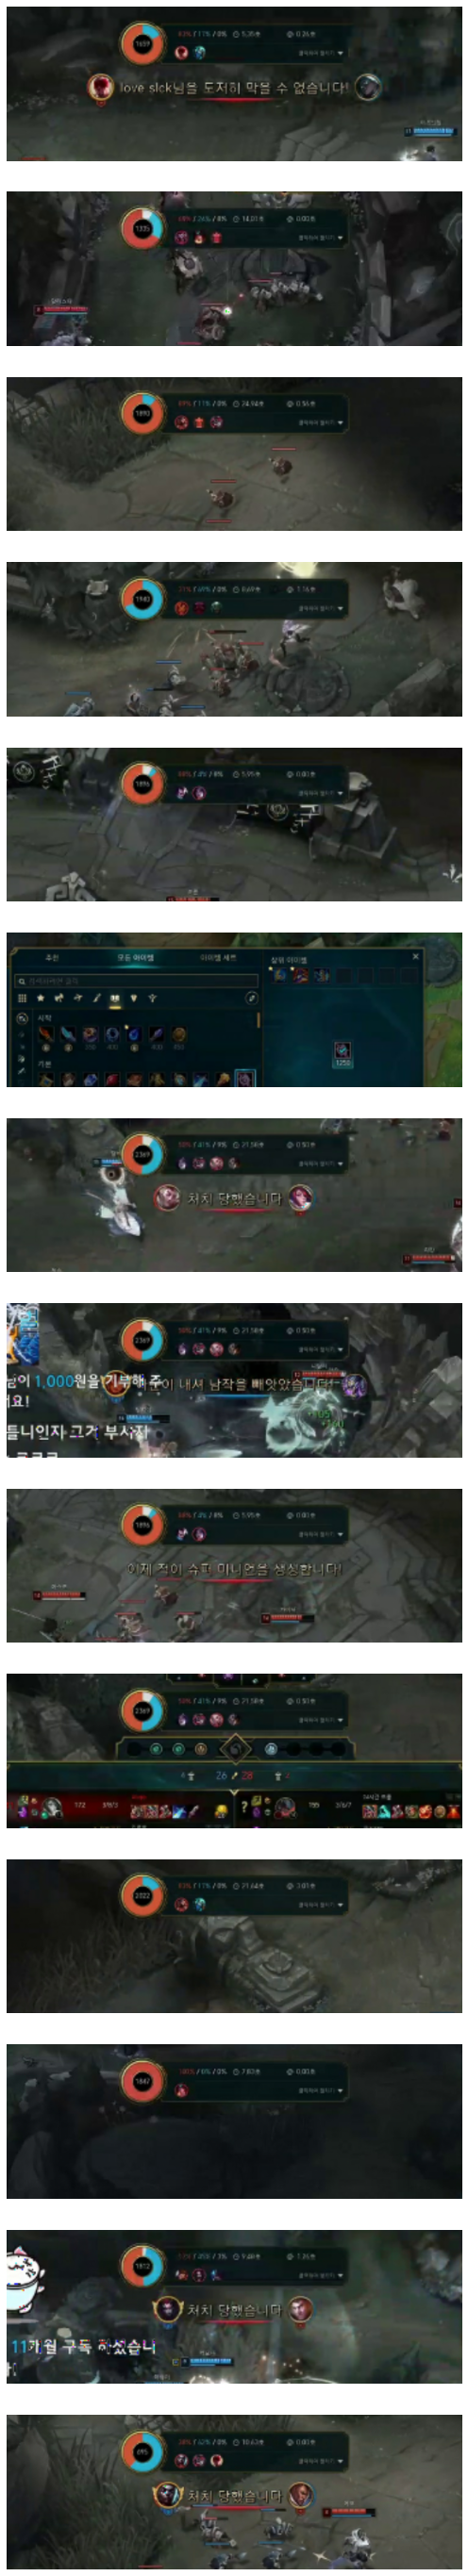

In [13]:
batch = renew_dataset.take(1)

for images, labels in batch:
    plt.figure(figsize = (20, 50))
    for i, image in enumerate(images):
        ax = plt.subplot(14, 1, i + 1)
        plt.imshow(image.numpy().astype('float32') / 255.)
        plt.axis('OFF')
        if i == 13:
            break
    break

## 8-1. 8차 학습 전 평가


### 7차 학습 모델 

- 기존 학습 방법들중 가장 성능이 좋은 모델 사용


### 3차 데이터 셋

- 위 문제점을 개선하기 위한 다른 창이 존재하는 데이터 셋
- kill 이미지 826
- non-kill 이미지 881


### 8차 학습 전 평가 특징

- 위에서 언급하였던 다른 창이 겹치는 킬 또는 이벤트에 대한 검출이 어려운 문제를 해결하기 위해서 다른 창이 겹치는 경우의 이미지만으로 데이터셋을 구성하였습니다.

- ROI 추출을 통해 기존 모델을 재사용할 수 있도록 하였습니다.

실제 우리의 모델에 대해서도 정확도가 낮게 나오는지 확인해보겠습니다.

In [14]:
# best 모델 로드하기

In [15]:
# best 모델 평가

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,190,560] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/vgg16/block1_conv1/Relu (defined at <ipython-input-15-ce4c4687476d>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_1800]

Function call stack:
test_function


## 8-2. 8차 학습 전 데이터 분리

데이터셋이 하나의 디렉토리에 존재하므로 학습용 데이터와 평가용 데이터를 분리합니다.

In [19]:
import os 
import numpy as np
import shutil
SPLIT_VAL = 0.2

ADD_TRAIN_PATH = './cropped_dataset/kill_log_dataset_3'
ADD_TEST_PATH = './cropped_dataset/kill_log_testset_3'

In [20]:
# 기존 디렉토리 삭제
shutil.rmtree(ADD_TRAIN_PATH)
shutil.rmtree(ADD_TEST_PATH)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './cropped_dataset/kill_log_dataset_3'

In [21]:
if not os.path.exists(ADD_TRAIN_PATH):
    os.mkdir(ADD_TRAIN_PATH)
    
if not os.path.exists(ADD_TEST_PATH):
    os.mkdir(ADD_TEST_PATH)

In [22]:
for directory_name in os.listdir(ADD_IMAGE_PATH):
    # kill_log, non_kill_log
    directory_path = os.path.join(ADD_IMAGE_PATH, directory_name)
    
    # train_directory 생성
    train_save_path = os.path.join(ADD_TRAIN_PATH, directory_name)
    if not os.path.exists(train_save_path):
        os.mkdir(train_save_path)
    # test_directory 생성
    test_save_path = os.path.join(ADD_TEST_PATH, directory_name)
    if not os.path.exists(test_save_path):
        os.mkdir(test_save_path)
    
    files = os.listdir(directory_path)
    
    # 전체 데이터 사이즈
    data_size = len(files)
    
    # 테스트 데이터 사이즈
    test_size = int(len(files) * 0.2)
    
    # 테스트 데이터로 선택되는 인덱스
    test_data = np.random.choice(data_size, test_size, replace = False)
    
    for i, file in enumerate(files):
        if i in test_data:
            shutil.copy(os.path.join(directory_path, file), test_save_path)
        else:
            shutil.copy(os.path.join(directory_path, file), train_save_path)


In [23]:
add_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TRAIN_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
)

add_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TEST_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
)

Found 1366 files belonging to 2 classes.
Found 341 files belonging to 2 classes.


## 8-3. 8차 학습 


### VGG19

- 4차 학습 모델 사용
- VGG16보다 단순한 ResNet50사용


### 1차 데이터셋 (기존 학습)

- kill 이미지 786
- non-kill 이미지 1832


### 1차 테스트셋

- kill 이미지 161
- non-kill 이미지 149


### 2차 데이터셋

- kill 이미지 1009
- non-kill 이미지 746


### 2차 테스트셋

- kill 이미지 252
- non-kill 이미지 186


### 3차 데이터셋

- kill 이미지 661
- non-kill 이미지 705


### 3차 테스트셋

- kill 이미지 165
- non-kill 이미지 176



### 8차 학습 특징

- ROI를 수행합니다.
- 3차 데이터 셋으로 최종 학습 모델을 평가합니다.
- 그 후, 최종 학습 모델을 3차 데이터 셋으로 추가 학습을 진행합니다.
- 전이학습을 위해 base_model에 대한 가중치 갱신을 멈춥니다.

In [16]:
# 학습 데이터셋 로드하기

NameError: name 'ADD_TRAIN_PATH' is not defined

In [42]:
# 평가 데이터셋 로드하기

Found 341 files belonging to 2 classes.


In [44]:
# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장. (모델을 저장하는 것은 ) 
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t8.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [46]:
# 전이학습을 위해 convolution layer를 동결시킨다.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 190, 560, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 14,731,265
Trainable params: 14,731,201
Non-trainable params: 64
______________________________________________

In [ ]:
# 전이학습을 위한 추가 학습 

In [2]:
# 모델 평가

In [4]:
# 가장 좋은 모델 로드

In [ ]:
# 가장 좋은 모델 평가

## 1, 2차에 대한 평가 데이터셋을 구현하여 함께 평가

In [5]:
# 1, 2차 데이터셋 로드하기

Found 310 files belonging to 2 classes.
Found 438 files belonging to 2 classes.


In [ ]:
# 1, 2차 데이터셋이 결합된 데이터셋

### 8차 학습 결과

- 1차, 2차 평가 데이터의 정확도는 ?%

기존 모델의 문제점이었던 로그와 창이 겹치는 경우에 대해서 분류가 잘되는 것을 확인할 수 있습니다. 정확도 또한 충분하기 때문에 8차학습의 모델을 최종 모델로 선정하고 해당 프로젝트를 마무리 합니다.



### 추가 구현 방향

- 3차 데이터셋까지 수집하였으나, 아직 모델을 구현하기에는 턱없이 부족합니다. 추가적인 데이터 수집을 통해 모델을 고도화합니다.
- 크리에이터의 방송영상이다보니 게임 영상 뿐 만아니라 다른 창이 함께 뜨는 경우가 존재하였습니다. 이러한 예외사항에 대한 처리도 함께 고려해야합니다.
